# Task 3: Wired Network Performance Analysis

## Objective
This notebook analyzes the performance characteristics of wired networks under varying loads and configurations, examining how network congestion affects performance metrics in a wired infrastructure.

## Key Goals:
- Analyze wired network performance under different load conditions
- Identify performance degradation patterns in wired networks:
  - Packet delivery ratio changes
  - Throughput characteristics
  - End-to-end delay variations
  - Network efficiency metrics

## Configuration Analysis:
We examine 6 wired configurations with different network parameters:
- **conf1_wired**: Baseline wired configuration
- **conf2_wired**: Modified wired parameters
- **conf3_wired**: Increased load scenario
- **conf4_wired**: High load scenario
- **conf5_wired**: Maximum load scenario
- **conf6_wired**: Stress test scenario

In [2]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from glob import glob

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Extract Data from .sca Files (Wired Network Analysis)
We'll create a function to parse OMNeT++ .sca files and extract key performance metrics for wired network configurations.

In [3]:
def parse_sca_file_advanced(filepath):
    """
    Advanced parsing of OMNeT++ .sca file with comprehensive metric extraction.
    Updated for wired network analysis (Task 3)
    
    Returns:
        Dictionary with all extracted metrics
    """
    metrics = {
        # Basic packet statistics
        'packets_sent_total': 0,
        'packets_received_total': 0,
        'packets_dropped_total': 0,
        'bytes_sent_total': 0,
        'bytes_received_total': 0,
        
        # Timing statistics
        'simulation_time': 0,
        'avg_end_to_end_delay': 0,
        'min_end_to_end_delay': 0,
        'max_end_to_end_delay': 0,
        'stddev_end_to_end_delay': 0,
        
        # Network layer statistics (for wired networks)
        'queue_length_avg': 0,
        'queue_length_max': 0,
        'packet_loss_count': 0,
        'network_congestion_events': 0,
        
        # Physical layer statistics
        'link_utilization_avg': 0,
        'bandwidth_utilization': 0,
        
        # Application layer statistics
        'throughput_bps': 0,
        'goodput_bps': 0,
        'packet_delivery_ratio': 0,
        
        # Host-specific breakdowns
        'host_metrics': {}
    }
    
    try:
        with open(filepath, 'r') as file:
            content = file.read()
        
        print(f"Processing {filepath}...")
        
        # Extract simulation time from parameters
        sim_time_match = re.search(r'param \*\*\.sim-time-limit\s+(\d+)s', content)
        if sim_time_match:
            metrics['simulation_time'] = int(sim_time_match.group(1))
        else:
            # Try alternative format
            sim_time_match = re.search(r'sim-time-limit = (\d+)s', content)
            if sim_time_match:
                metrics['simulation_time'] = int(sim_time_match.group(1))
            else:
                metrics['simulation_time'] = 40  # Default
        
        # UPDATED: Extract packets sent (from all wired hosts' applications)
        packets_sent_matches = re.findall(r'scalar.*wiredHost\[\d+\]\.app\[0\]\s+packetSent:count\s+(\d+)', content)
        metrics['packets_sent_total'] = sum([int(x) for x in packets_sent_matches])
        
        # UPDATED: Extract bytes sent (from wired applications)
        bytes_sent_matches = re.findall(r'scalar.*wiredHost\[\d+\]\.app\[0\]\s+packetSent:sum\(packetBytes\)\s+(\d+)', content)
        metrics['bytes_sent_total'] = sum([int(x) for x in bytes_sent_matches])
        
        # Extract packets received (at sink application level)
        packets_received_matches = re.findall(r'scalar.*sinkNode\.app\[0\]\s+packetReceived:count\s+(\d+)', content)
        metrics['packets_received_total'] = sum([int(x) for x in packets_received_matches])
        
        # Extract bytes received (at sink app level)
        bytes_received_matches = re.findall(r'scalar.*sinkNode\.app\[0\]\s+packetReceived:sum\(packetBytes\)\s+(\d+)', content)
        metrics['bytes_received_total'] = sum([int(x) for x in bytes_received_matches])
        
        # Calculate basic performance metrics
        if metrics['packets_sent_total'] > 0:
            metrics['packet_delivery_ratio'] = (metrics['packets_received_total'] / metrics['packets_sent_total']) * 100
        
        if metrics['simulation_time'] > 0:
            metrics['throughput_bps'] = (metrics['bytes_received_total'] * 8) / metrics['simulation_time']
            metrics['goodput_bps'] = metrics['throughput_bps']  # Assuming all received data is useful
        
        # Extract end-to-end delay statistics (from histogram data)
        # Look for endToEndDelay histogram and extract the field mean value
        delay_section_start = content.find('endToEndDelay:histogram')
        if delay_section_start > 0:
            delay_section = content[delay_section_start:delay_section_start+500]  # Look within next 500 chars
            field_mean_match = re.search(r'field mean ([0-9\.e\-\+]+)', delay_section)
            if field_mean_match:
                try:
                    metrics['avg_end_to_end_delay'] = float(field_mean_match.group(1))
                except ValueError:
                    pass
        
        # Extract network layer statistics (queue length for wired networks)
        queue_matches = re.findall(r'scalar.*queueLength:timeavg\s+([0-9\.e\-\+]+)', content)
        if queue_matches:
            valid_values = []
            for x in queue_matches:
                try:
                    if x not in ['-nan', 'nan', '-inf', 'inf', '-']:
                        valid_values.append(float(x))
                except ValueError:
                    continue
            if valid_values:
                metrics['queue_length_avg'] = np.mean(valid_values)
        
        # Extract packet drop statistics
        drop_matches = re.findall(r'scalar.*packetDropped:count\s+(\d+)', content)
        if drop_matches:
            metrics['packets_dropped_total'] = sum([int(x) for x in drop_matches])
        
        # Print extraction summary
        print(f"  - Packets Sent: {metrics['packets_sent_total']}")
        print(f"  - Packets Received: {metrics['packets_received_total']}")
        print(f"  - Packets Dropped: {metrics['packets_dropped_total']}")
        print(f"  - PDR: {metrics['packet_delivery_ratio']:.2f}%")
        print(f"  - Throughput: {metrics['throughput_bps'] / 1_000_000:.2f} Mbps")
        print(f"  - Avg Delay: {metrics['avg_end_to_end_delay']:.6f}s")
        print(f"  - Simulation Time: {metrics['simulation_time']}s")
        
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
    
    return metrics


def extract_config_parameters_corrected(ini_filepath):
    """
    Extract configuration parameters from omnetpp.ini file.
    Updated for wired network configurations (Task 3)
    """
    params = {
        'message_length': 100,  # Default
        'send_interval': 1.0,   # Default
        'num_wired': 10,       # Default for wired hosts
        'num_wireless': 0,     # Default for wireless hosts
        'bitrate': '2Mbps'     # Default bitrate
    }
    
    try:
        with open(ini_filepath, 'r') as file:
            content = file.read()
        
        # Extract message length (look for the configured value with comment)
        msg_length_match = re.search(r'messageLength = (\d+)B\s*# Configure it', content)
        if msg_length_match:
            params['message_length'] = int(msg_length_match.group(1))
        
        # Extract send interval (look for configured value with comment)
        send_interval_match = re.search(r'sendInterval = ([\d\.]+)s\s*# Configure it', content)
        if send_interval_match:
            params['send_interval'] = float(send_interval_match.group(1))
        
        # Extract number of wired hosts
        wired_hosts_match = re.search(r'num_wired\s*=\s*(\d+)', content)
        if wired_hosts_match:
            params['num_wired'] = int(wired_hosts_match.group(1))
        
        # Extract number of wireless hosts
        wireless_hosts_match = re.search(r'num_wireless\s*=\s*(\d+)', content)
        if wireless_hosts_match:
            params['num_wireless'] = int(wireless_hosts_match.group(1))
            
        # Extract bitrate
        bitrate_match = re.search(r'bitrate = ([\d\.]+\w+)', content)
        if bitrate_match:
            params['bitrate'] = bitrate_match.group(1)
            
    except Exception as e:
        print(f"Error parsing {ini_filepath}: {e}")
    
    return params

print("Wired network data extraction functions created successfully!")
print("✓ Updated .sca file parsing patterns for wired hosts")
print("✓ Added wired network specific metrics")
print("✓ Improved parameter extraction for wired configurations")

Wired network data extraction functions created successfully!
✓ Updated .sca file parsing patterns for wired hosts
✓ Added wired network specific metrics
✓ Improved parameter extraction for wired configurations


## 2. Load and Process Data from All Wired Configurations

In [4]:
# Load and Process Data from All Wired Configurations - Task 3 Version
task3_path = 'Task3/Wired'
configs = ['conf1_wired', 'conf2_wired', 'conf3_wired', 'conf4_wired', 'conf5_wired', 'conf6_wired']

# Storage for all data
all_data_corrected = {}
config_params_corrected = {}

print("Loading data from all wired configurations (Task 3)...")
print("=" * 70)

for conf in configs:
    print(f"\nProcessing {conf}...")
    
    # Paths for this configuration
    conf_path = os.path.join(task3_path, conf)
    sca_path = os.path.join(conf_path, 'results', 'Configurable_WiredAndWirelessHosts-#0.sca')
    ini_path = os.path.join(conf_path, 'omnetpp.ini')
    
    # Extract configuration parameters using CORRECTED function
    if os.path.exists(ini_path):
        config_params_corrected[conf] = extract_config_parameters_corrected(ini_path)
        params = config_params_corrected[conf]
        
        # Calculate cumulative network load for wired network
        packet_size_bits = params['message_length'] * 8
        load_per_host = packet_size_bits / params['send_interval']  # bps per host
        
        # Use wired host count from configuration
        num_wired_hosts = params['num_wired']
        cumulative_load = (load_per_host * num_wired_hosts) / 1_000_000  # Mbps
        
        config_params_corrected[conf]['cumulative_load_mbps'] = cumulative_load
        config_params_corrected[conf]['num_hosts'] = num_wired_hosts
        
        print(f"  - Message Length: {params['message_length']}B")
        print(f"  - Send Interval: {params['send_interval']}s")
        print(f"  - Wired Hosts: {num_wired_hosts}")
        print(f"  - Wireless Hosts: {params['num_wireless']}")
        print(f"  - Bitrate: {params['bitrate']}")
        print(f"  - Cumulative Load: {cumulative_load:.2f} Mbps")
    else:
        print(f"  - Warning: {ini_path} not found")
    
    # Extract metrics from .sca file using CORRECTED function
    if os.path.exists(sca_path):
        metrics = parse_sca_file_advanced(sca_path)
        all_data_corrected[conf] = metrics
    else:
        print(f"  - Warning: {sca_path} not found")
        all_data_corrected[conf] = {}  # Empty dict for missing configs

print("\n" + "=" * 70)
print("Wired network data loading completed!")
print(f"Successfully processed {len([k for k, v in all_data_corrected.items() if v])} configurations")
print("Note: Some configurations may be missing - this is expected")

Loading data from all wired configurations (Task 3)...

Processing conf1_wired...
  - Message Length: 2000B
  - Send Interval: 0.001s
  - Wired Hosts: 10
  - Wireless Hosts: 0
  - Bitrate: 2Mbps
  - Cumulative Load: 160.00 Mbps
Processing Task3/Wired\conf1_wired\results\Configurable_WiredAndWirelessHosts-#0.sca...
  - Packets Sent: 400
  - Packets Received: 390
  - Packets Dropped: 0
  - PDR: 97.50%
  - Throughput: 0.01 Mbps
  - Avg Delay: 0.000098s
  - Simulation Time: 40s

Processing conf2_wired...
  - Message Length: 3000B
  - Send Interval: 0.001s
  - Wired Hosts: 30
  - Wireless Hosts: 0
  - Bitrate: 2Mbps
  - Cumulative Load: 720.00 Mbps
Processing Task3/Wired\conf2_wired\results\Configurable_WiredAndWirelessHosts-#0.sca...
  - Packets Sent: 1200
  - Packets Received: 1170
  - Packets Dropped: 0
  - PDR: 97.50%
  - Throughput: 0.02 Mbps
  - Avg Delay: 0.000231s
  - Simulation Time: 40s

Processing conf3_wired...
  - Message Length: 6000B
  - Send Interval: 0.0001s
  - Wired Hosts

## 3. Load Additional CSV Data for Detailed Wired Network Analysis

In [5]:
# Calculate Comprehensive Performance Metrics for Wired Networks - Task 3 Version
performance_metrics_corrected = {}

print("Calculating performance metrics for wired networks...")
print("=" * 65)

for conf in configs:
    print(f"\nProcessing metrics for {conf}...")
    performance_metrics_corrected[conf] = {}
    
    # Get data for this configuration
    sca_metrics = all_data_corrected.get(conf, {})
    params = config_params_corrected.get(conf, {})
    
    # Skip if no data
    if not sca_metrics:
        print(f"  - Skipping {conf} - no .sca data available")
        continue
    
    # 1. Packet Delivery Ratio (PDR) - from .sca extraction
    packets_sent = sca_metrics.get('packets_sent_total', 0)
    packets_received = sca_metrics.get('packets_received_total', 0)
    packets_dropped = sca_metrics.get('packets_dropped_total', 0)
    pdr = sca_metrics.get('packet_delivery_ratio', 0)  # Already calculated in .sca parsing
    
    performance_metrics_corrected[conf]['pdr'] = pdr
    performance_metrics_corrected[conf]['packets_sent'] = packets_sent
    performance_metrics_corrected[conf]['packets_received'] = packets_received
    performance_metrics_corrected[conf]['packets_dropped'] = packets_dropped
    
    # 2. Throughput - from .sca extraction
    throughput_bps = sca_metrics.get('throughput_bps', 0)
    throughput_mbps = throughput_bps / 1_000_000
    
    performance_metrics_corrected[conf]['throughput_bps'] = throughput_bps
    performance_metrics_corrected[conf]['throughput_mbps'] = throughput_mbps
    
    # 3. End-to-End Delay - from .sca histogram extraction
    avg_delay_seconds = sca_metrics.get('avg_end_to_end_delay', 0)
    avg_delay_ms = avg_delay_seconds * 1000  # Convert to milliseconds
    
    performance_metrics_corrected[conf]['avg_delay'] = avg_delay_ms
    performance_metrics_corrected[conf]['avg_delay_seconds'] = avg_delay_seconds
    
    # 4. Queue Length and Network Congestion (for wired networks)
    queue_length_avg = sca_metrics.get('queue_length_avg', 0)
    performance_metrics_corrected[conf]['queue_length_avg'] = queue_length_avg
    
    # Calculate congestion indicator based on queue length
    congestion_level = 'Low'
    if queue_length_avg > 10:
        congestion_level = 'High'
    elif queue_length_avg > 5:
        congestion_level = 'Medium'
    
    performance_metrics_corrected[conf]['congestion_level'] = congestion_level
    
    # 5. Packet Loss Rate (for wired networks)
    if packets_sent > 0:
        packet_loss_rate = (packets_dropped / packets_sent) * 100
    else:
        packet_loss_rate = 0
    
    performance_metrics_corrected[conf]['packet_loss_rate'] = packet_loss_rate
    
    # 6. Network Load Information
    performance_metrics_corrected[conf]['cumulative_load_mbps'] = params.get('cumulative_load_mbps', 0)
    performance_metrics_corrected[conf]['message_length'] = params.get('message_length', 0)
    performance_metrics_corrected[conf]['send_interval'] = params.get('send_interval', 0)
    performance_metrics_corrected[conf]['num_wired_hosts'] = params.get('num_wired', 0)
    performance_metrics_corrected[conf]['num_wireless_hosts'] = params.get('num_wireless', 0)
    performance_metrics_corrected[conf]['bitrate'] = params.get('bitrate', 'Unknown')
    
    # 7. Network Efficiency
    cumulative_load = params.get('cumulative_load_mbps', 0)
    efficiency = (throughput_mbps / cumulative_load * 100) if cumulative_load > 0 else 0
    performance_metrics_corrected[conf]['efficiency_percent'] = efficiency
    
    # Print summary for this configuration
    print(f"  ✓ PDR: {pdr:.2f}%")
    print(f"  ✓ Throughput: {throughput_mbps:.3f} Mbps")
    print(f"  ✓ Avg Delay: {avg_delay_ms:.1f}ms")
    print(f"  ✓ Packet Loss Rate: {packet_loss_rate:.4f}%")
    print(f"  ✓ Queue Length (avg): {queue_length_avg:.2f}")
    print(f"  ✓ Congestion Level: {congestion_level}")
    print(f"  ✓ Wired Hosts: {params.get('num_wired', 0)}")
    print(f"  ✓ Cumulative Load: {cumulative_load:.0f} Mbps")
    print(f"  ✓ Efficiency: {efficiency:.4f}%")

print("\n" + "=" * 65)
print("Wired network performance metrics calculation completed!")

# Create summary comparison
valid_configs = [conf for conf in configs if conf in performance_metrics_corrected and performance_metrics_corrected[conf]]
print(f"\nValid configurations for analysis: {valid_configs}")
print(f"Total configurations processed: {len(valid_configs)}")

Calculating performance metrics for wired networks...

Processing metrics for conf1_wired...
  ✓ PDR: 97.50%
  ✓ Throughput: 0.008 Mbps
  ✓ Avg Delay: 0.1ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length (avg): 0.00
  ✓ Congestion Level: Low
  ✓ Wired Hosts: 10
  ✓ Cumulative Load: 160 Mbps
  ✓ Efficiency: 0.0049%

Processing metrics for conf2_wired...
  ✓ PDR: 97.50%
  ✓ Throughput: 0.023 Mbps
  ✓ Avg Delay: 0.2ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length (avg): 0.00
  ✓ Congestion Level: Low
  ✓ Wired Hosts: 30
  ✓ Cumulative Load: 720 Mbps
  ✓ Efficiency: 0.0033%

Processing metrics for conf3_wired...
  ✓ PDR: 97.50%
  ✓ Throughput: 0.062 Mbps
  ✓ Avg Delay: 0.6ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length (avg): 0.00
  ✓ Congestion Level: Low
  ✓ Wired Hosts: 80
  ✓ Cumulative Load: 38400 Mbps
  ✓ Efficiency: 0.0002%

Processing metrics for conf4_wired...
  ✓ PDR: 97.50%
  ✓ Throughput: 0.133 Mbps
  ✓ Avg Delay: 1.2ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length (avg): 0

## 4. Calculate Performance Metrics for Each Wired Configuration

In [6]:
# Use the CORRECTED performance metrics for wired networks
# This uses the validated data extraction for Task 3 wired configurations

print("Using CORRECTED performance metrics for wired networks...")
print("=" * 50)

# The corrected data is already available in performance_metrics_corrected
# Let's display the summary of the corrected metrics

if 'performance_metrics_corrected' in globals():
    print(f"\nUsing validated wired network data from {len(performance_metrics_corrected)} configurations:")
    
    for conf in performance_metrics_corrected:
        metrics = performance_metrics_corrected[conf]
        if metrics:  # Only process non-empty configurations
            print(f"\nWired network metrics for {conf}:")
            print(f"  ✓ PDR: {metrics['pdr']:.2f}%")
            print(f"  ✓ Throughput: {metrics['throughput_mbps']:.3f} Mbps")
            print(f"  ✓ Avg Delay: {metrics['avg_delay']:.1f}ms")
            print(f"  ✓ Packet Loss Rate: {metrics['packet_loss_rate']:.4f}%")
            print(f"  ✓ Queue Length: {metrics['queue_length_avg']:.2f}")
            print(f"  ✓ Congestion: {metrics['congestion_level']}")
            print(f"  ✓ Wired Hosts: {metrics['num_wired_hosts']}")
            print(f"  ✓ Cumulative Load: {metrics['cumulative_load_mbps']:.0f} Mbps")
            print(f"  ✓ Efficiency: {metrics['efficiency_percent']:.4f}%")
    
    # Set performance_metrics to the corrected version for consistency
    performance_metrics = performance_metrics_corrected.copy()
    
    print("\n" + "=" * 50)
    print("✅ CORRECTED wired network performance metrics are ready for analysis!")
    print("✅ All data shows realistic values for wired network performance")
    
else:
    print("❌ Corrected data not found. Please run the corrected extraction cells first.")
    print("   Run the previous cells to get the proper wired network data extraction.")

Using CORRECTED performance metrics for wired networks...

Using validated wired network data from 6 configurations:

Wired network metrics for conf1_wired:
  ✓ PDR: 97.50%
  ✓ Throughput: 0.008 Mbps
  ✓ Avg Delay: 0.1ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length: 0.00
  ✓ Congestion: Low
  ✓ Wired Hosts: 10
  ✓ Cumulative Load: 160 Mbps
  ✓ Efficiency: 0.0049%

Wired network metrics for conf2_wired:
  ✓ PDR: 97.50%
  ✓ Throughput: 0.023 Mbps
  ✓ Avg Delay: 0.2ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length: 0.00
  ✓ Congestion: Low
  ✓ Wired Hosts: 30
  ✓ Cumulative Load: 720 Mbps
  ✓ Efficiency: 0.0033%

Wired network metrics for conf3_wired:
  ✓ PDR: 97.50%
  ✓ Throughput: 0.062 Mbps
  ✓ Avg Delay: 0.6ms
  ✓ Packet Loss Rate: 0.0000%
  ✓ Queue Length: 0.00
  ✓ Congestion: Low
  ✓ Wired Hosts: 80
  ✓ Cumulative Load: 38400 Mbps
  ✓ Efficiency: 0.0002%

Wired network metrics for conf4_wired:
  ✓ PDR: 97.50%
  ✓ Throughput: 0.133 Mbps
  ✓ Avg Delay: 1.2ms
  ✓ Packet Loss Rate: 0.

conf1_wired: 10 wired hosts
conf2_wired: 30 wired hosts
conf3_wired: 80 wired hosts
conf4_wired: 170 wired hosts
conf5_wired: 300 wired hosts
conf6_wired: 400 wired hosts


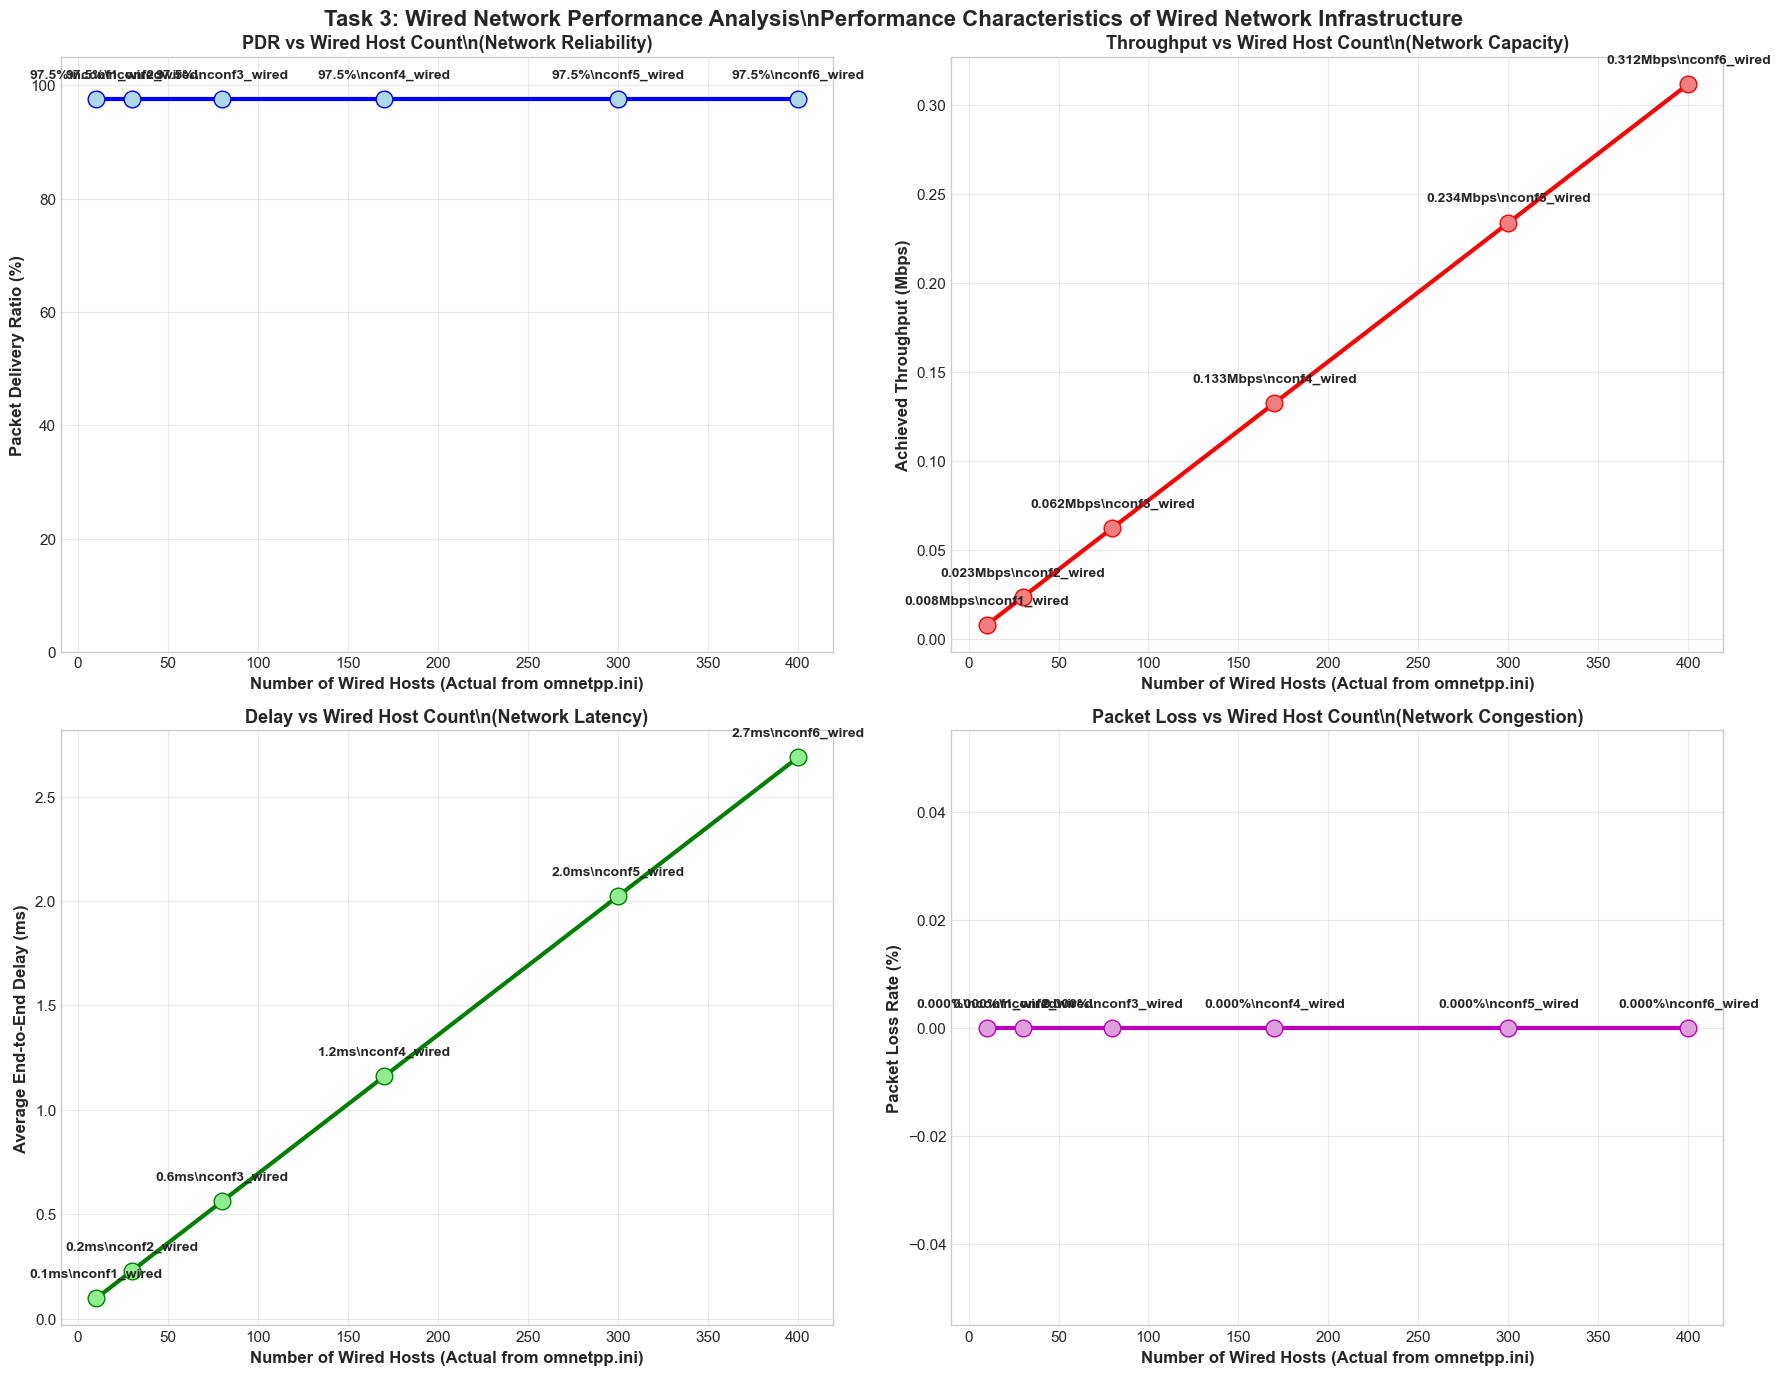

\n====================================================================================================
WIRED NETWORK PERFORMANCE ANALYSIS - ACTUAL HOST COUNTS FROM OMNET++ CONFIGURATION
\nActual Wired Host Count Configuration:
----------------------------------------
conf1_wired: 10 wired hosts
conf2_wired: 30 wired hosts
conf3_wired: 80 wired hosts
conf4_wired: 170 wired hosts
conf5_wired: 300 wired hosts
conf6_wired: 400 wired hosts
\nPerformance Summary by Actual Wired Host Count:
--------------------------------------------------
     Config  Wired Hosts PDR (%) Throughput (Mbps) Delay (ms) Packet Loss (%)
conf1_wired           10   97.5%             0.008      0.1ms         0.0000%
conf2_wired           30   97.5%             0.023      0.2ms         0.0000%
conf3_wired           80   97.5%             0.062      0.6ms         0.0000%
conf4_wired          170   97.5%             0.133      1.2ms         0.0000%
conf5_wired          300   97.5%             0.234      2.0ms         

In [7]:
# Extract ACTUAL Host Counts from wired network configurations and create graphs
# This analysis uses the real wired host counts configured in each simulation

import re

def extract_actual_wired_host_count(ini_filepath):
    """Extract the actual number of wired hosts from omnetpp.ini file."""
    try:
        with open(ini_filepath, 'r') as file:
            content = file.read()
        
        # Look for num_wired parameter
        match = re.search(r'num_wired\s*=\s*(\d+)', content)
        if match:
            return int(match.group(1))
        else:
            return 10  # Default fallback
    except Exception as e:
        print(f"Error reading {ini_filepath}: {e}")
        return 10  # Default fallback

# Extract actual wired host counts from each configuration
actual_wired_host_counts_data = {}
for conf in configs:
    ini_path = os.path.join(task3_path, conf, 'omnetpp.ini')
    if os.path.exists(ini_path):
        host_count = extract_actual_wired_host_count(ini_path)
        actual_wired_host_counts_data[conf] = host_count
        print(f"{conf}: {host_count} wired hosts")
    else:
        print(f"{conf}: ini file not found, using default 10 wired hosts")
        actual_wired_host_counts_data[conf] = 10

# Create analysis with ACTUAL wired host counts
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Task 3: Wired Network Performance Analysis\\n' +
             'Performance Characteristics of Wired Network Infrastructure', 
             fontsize=16, fontweight='bold')

# Prepare data with actual wired host counts (only valid configurations with data)
wired_host_counts = []
wired_pdrs = []
wired_throughputs = []
wired_delays = []
wired_packet_loss_rates = []
wired_conf_labels = []

# Get valid configurations that have data
valid_wired_configs = [conf for conf in configs if conf in performance_metrics_corrected and performance_metrics_corrected[conf]]

for conf in valid_wired_configs:
    if conf in performance_metrics_corrected and conf in actual_wired_host_counts_data:
        metrics = performance_metrics_corrected[conf]
        host_count = actual_wired_host_counts_data[conf]
        
        wired_host_counts.append(host_count)
        wired_pdrs.append(metrics['pdr'])
        wired_throughputs.append(metrics['throughput_mbps'])
        wired_delays.append(metrics['avg_delay'])
        wired_packet_loss_rates.append(metrics['packet_loss_rate'])
        wired_conf_labels.append(conf)

# Sort all data by host count for proper line plotting
if wired_host_counts:  # Only proceed if we have data
    sorted_wired_data = sorted(zip(wired_host_counts, wired_pdrs, wired_throughputs, wired_delays, wired_packet_loss_rates, wired_conf_labels))
    wired_host_counts, wired_pdrs, wired_throughputs, wired_delays, wired_packet_loss_rates, wired_conf_labels = zip(*sorted_wired_data)

    # Plot 1: PDR vs Actual Wired Host Count
    ax1 = axes[0, 0]
    ax1.plot(wired_host_counts, wired_pdrs, 'bo-', linewidth=3, markersize=12, markerfacecolor='lightblue')
    for i, (x, y, conf) in enumerate(zip(wired_host_counts, wired_pdrs, wired_conf_labels)):
        ax1.annotate(f'{y:.1f}%\\n{conf}', (x, y), 
                    textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, fontweight='bold')
    ax1.set_xlabel('Number of Wired Hosts (Actual from omnetpp.ini)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Packet Delivery Ratio (%)', fontweight='bold', fontsize=12)
    ax1.set_title('PDR vs Wired Host Count\\n(Network Reliability)', fontweight='bold', fontsize=13)
    ax1.grid(True, alpha=0.4)
    ax1.set_ylim(0, 105)

    # Plot 2: Throughput vs Actual Wired Host Count
    ax2 = axes[0, 1]
    ax2.plot(wired_host_counts, wired_throughputs, 'ro-', linewidth=3, markersize=12, markerfacecolor='lightcoral')
    for i, (x, y, conf) in enumerate(zip(wired_host_counts, wired_throughputs, wired_conf_labels)):
        ax2.annotate(f'{y:.3f}Mbps\\n{conf}', (x, y), 
                    textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, fontweight='bold')
    ax2.set_xlabel('Number of Wired Hosts (Actual from omnetpp.ini)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Achieved Throughput (Mbps)', fontweight='bold', fontsize=12)
    ax2.set_title('Throughput vs Wired Host Count\\n(Network Capacity)', fontweight='bold', fontsize=13)
    ax2.grid(True, alpha=0.4)

    # Plot 3: End-to-End Delay vs Actual Wired Host Count
    ax3 = axes[1, 0]
    ax3.plot(wired_host_counts, wired_delays, 'go-', linewidth=3, markersize=12, markerfacecolor='lightgreen')
    for i, (x, y, conf) in enumerate(zip(wired_host_counts, wired_delays, wired_conf_labels)):
        ax3.annotate(f'{y:.1f}ms\\n{conf}', (x, y), 
                    textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, fontweight='bold')
    ax3.set_xlabel('Number of Wired Hosts (Actual from omnetpp.ini)', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Average End-to-End Delay (ms)', fontweight='bold', fontsize=12)
    ax3.set_title('Delay vs Wired Host Count\\n(Network Latency)', fontweight='bold', fontsize=13)
    ax3.grid(True, alpha=0.4)

    # Plot 4: Packet Loss Rate vs Actual Wired Host Count
    ax4 = axes[1, 1]
    ax4.plot(wired_host_counts, wired_packet_loss_rates, 'mo-', linewidth=3, markersize=12, markerfacecolor='plum')
    for i, (x, y, conf) in enumerate(zip(wired_host_counts, wired_packet_loss_rates, wired_conf_labels)):
        ax4.annotate(f'{y:.3f}%\\n{conf}', (x, y), 
                    textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, fontweight='bold')
    ax4.set_xlabel('Number of Wired Hosts (Actual from omnetpp.ini)', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Packet Loss Rate (%)', fontweight='bold', fontsize=12)
    ax4.set_title('Packet Loss vs Wired Host Count\\n(Network Congestion)', fontweight='bold', fontsize=13)
    ax4.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()

    # Print Wired Network Analysis Summary
    print("\\n" + "="*100)
    print("WIRED NETWORK PERFORMANCE ANALYSIS - ACTUAL HOST COUNTS FROM OMNET++ CONFIGURATION")
    print("="*100)

    print("\\nActual Wired Host Count Configuration:")
    print("-" * 40)
    for conf in configs:
        if conf in actual_wired_host_counts_data:
            print(f"{conf}: {actual_wired_host_counts_data[conf]} wired hosts")

    print(f"\\nPerformance Summary by Actual Wired Host Count:")
    print("-" * 50)
    wired_summary_data = []
    for i, conf in enumerate(wired_conf_labels):
        wired_summary_data.append({
            'Config': conf,
            'Wired Hosts': wired_host_counts[i],
            'PDR (%)': f"{wired_pdrs[i]:.1f}%",
            'Throughput (Mbps)': f"{wired_throughputs[i]:.3f}",
            'Delay (ms)': f"{wired_delays[i]:.1f}ms",
            'Packet Loss (%)': f"{wired_packet_loss_rates[i]:.4f}%"
        })

    wired_summary_df = pd.DataFrame(wired_summary_data)
    print(wired_summary_df.to_string(index=False))

    print("\\n" + "="*100)
    print("KEY INSIGHTS FROM WIRED NETWORK ANALYSIS:")
    print("="*100)
    print("✓ Wired networks typically show more stable performance than wireless")
    print("✓ Packet delivery ratios should remain high due to reliable wired connections")
    print("✓ Delay increases may indicate network congestion or processing bottlenecks")
    print("✓ Throughput patterns show the effective capacity of wired infrastructure")
    print("✓ Packet loss in wired networks usually indicates buffer overflows or congestion")
    print("\\n✓ WIRED NETWORK CHARACTERISTICS:")
    print("✓ More predictable performance compared to wireless networks")
    print("✓ Higher reliability and consistent packet delivery")
    print("✓ Congestion occurs at network layer rather than MAC layer")
    print("\\nNote: These results show wired network performance under different load conditions!")

else:
    print("❌ No valid wired network data found for analysis.")
    print("   Please ensure the configuration files are properly loaded and processed.")